# Setup

In [1]:
import numpy as np
import pandas as pd
import numpy.linalg as linalg
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv("data/ml-100k/u.data",
                 sep="\t",
                 names=["userId","movieId","rating","timestamp"],
                 engine="python")
print(df.head())


   userId  movieId  rating  timestamp
0     196      242       3  881250949
1     186      302       3  891717742
2      22      377       1  878887116
3     244       51       2  880606923
4     166      346       1  886397596


In [3]:
from hyper_param_search import grid_search_funksvd

# Hyper parameter search

In [4]:
lr_candidates     = [0.001, 0.005, 0.01]
lambda_candidates = [0.001, 0.01, 0.1]
K_candidates      = [10, 20, 50]
results = grid_search_funksvd(df,
                              lr_candidates,
                              lambda_candidates,
                              K_candidates,
                              n_epochs=20)
print(results.sort_values('val_rmse').head())

✔️ Grid search done, results saved to 'hyperparam_results.csv'
      lr  lambda   K  train_rmse  val_rmse
23  0.01   0.010  50    0.758847  0.931545
20  0.01   0.001  50    0.731139  0.934917
22  0.01   0.010  20    0.812454  0.936460
19  0.01   0.001  20    0.792469  0.938638
21  0.01   0.010  10    0.841406  0.942966


# Model Optimized with ALS

In [4]:
# 1. DATA PREPARATION -------------------------------------------
# keep only the three columns we need
df = df[['userId','movieId','rating']]

# map original user/movie IDs to 0-based indices
user_ids = df['userId'].unique()
movie_ids = df['movieId'].unique()
u2idx = {u:i for i,u in enumerate(user_ids)}
i2idx = {m:i for i,m in enumerate(movie_ids)}
n_users, n_items = len(user_ids), len(movie_ids)

# split into 80% train, 20% test
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# build list of (u_idx, i_idx, rating) for train and test
train_samples = [
    (u2idx[u], i2idx[m], r)
    for u, m, r in zip(train_df.userId, train_df.movieId, train_df.rating)
]
# for test, drop any (u,m) not seen in train
test_samples = []
for u, m, r in zip(test_df.userId, test_df.movieId, test_df.rating):
    u_idx = u2idx.get(u, None)
    i_idx = i2idx.get(m, None)
    if u_idx is not None and i_idx is not None:
        test_samples.append((u_idx, i_idx, r))

# 2. PARAMETER INITIALIZATION ----------------------------------
K        = 50      # number of latent factors
lr       = 0.01   # learning rate γ
lmbda    = 0.01    # regularization λ
n_epochs = 20      # number of SGD passes

# randomly initialize P (users) and Q (items)
P = np.random.normal(scale=0.01, size=(n_users, K))
Q = np.random.normal(scale=0.01, size=(n_items, K))

# Preprocess: build rating dicts for fast lookup
user_ratings = defaultdict(list)
item_ratings = defaultdict(list)
for u, i, r in train_samples:
    user_ratings[u].append((i, r))
    item_ratings[i].append((u, r))

# 3. ALS TRAINING ----------------------------------------------

train_rmse_list = []
test_rmse_list = []

for epoch in range(1, n_epochs + 1):
    # === Update user factors P ===
    for u in range(n_users):
        rated_items = user_ratings[u]
        if not rated_items:
            continue
        A = np.zeros((K, K))
        b = np.zeros(K)
        for i, r_ui in rated_items:
            q_i = Q[i]
            A += np.outer(q_i, q_i)
            b += r_ui * q_i
        A += lmbda * np.eye(K)
        P[u] = linalg.solve(A, b)

    # === Update item factors Q ===
    for i in range(n_items):
        rated_by_users = item_ratings[i]
        if not rated_by_users:
            continue
        A = np.zeros((K, K))
        b = np.zeros(K)
        for u, r_ui in rated_by_users:
            p_u = P[u]
            A += np.outer(p_u, p_u)
            b += r_ui * p_u
        A += lmbda * np.eye(K)
        Q[i] = linalg.solve(A, b)

    # === Evaluate RMSE ===
    train_se = sum((r - P[u].dot(Q[i]))**2 for u, i, r in train_samples)
    train_rmse = np.sqrt(train_se / len(train_samples))

    test_se = sum((r - P[u].dot(Q[i]))**2 for u, i, r in test_samples)
    test_rmse = np.sqrt(test_se / len(test_samples))

    train_rmse_list.append(train_rmse)
    test_rmse_list.append(test_rmse)


    print(f"Epoch {epoch:02d}/{n_epochs} — "
          f"Train RMSE: {train_rmse:.4f}, "
          f"Test RMSE:  {test_rmse:.4f}")


Epoch 01/20 — Train RMSE: 0.9122, Test RMSE:  4.8599
Epoch 02/20 — Train RMSE: 0.4431, Test RMSE:  2.0708
Epoch 03/20 — Train RMSE: 0.3549, Test RMSE:  1.8295
Epoch 04/20 — Train RMSE: 0.3132, Test RMSE:  1.8020
Epoch 05/20 — Train RMSE: 0.2876, Test RMSE:  1.8296
Epoch 06/20 — Train RMSE: 0.2700, Test RMSE:  1.8491
Epoch 07/20 — Train RMSE: 0.2568, Test RMSE:  1.8738
Epoch 08/20 — Train RMSE: 0.2462, Test RMSE:  1.8952
Epoch 09/20 — Train RMSE: 0.2374, Test RMSE:  1.9233
Epoch 10/20 — Train RMSE: 0.2301, Test RMSE:  1.9447
Epoch 11/20 — Train RMSE: 0.2239, Test RMSE:  1.9547
Epoch 12/20 — Train RMSE: 0.2183, Test RMSE:  1.9795
Epoch 13/20 — Train RMSE: 0.2134, Test RMSE:  2.0060
Epoch 14/20 — Train RMSE: 0.2090, Test RMSE:  2.0237
Epoch 15/20 — Train RMSE: 0.2050, Test RMSE:  2.0397
Epoch 16/20 — Train RMSE: 0.2014, Test RMSE:  2.0556
Epoch 17/20 — Train RMSE: 0.1981, Test RMSE:  2.0731
Epoch 18/20 — Train RMSE: 0.1950, Test RMSE:  2.0900
Epoch 19/20 — Train RMSE: 0.1922, Test RMSE:  

# Training Curve

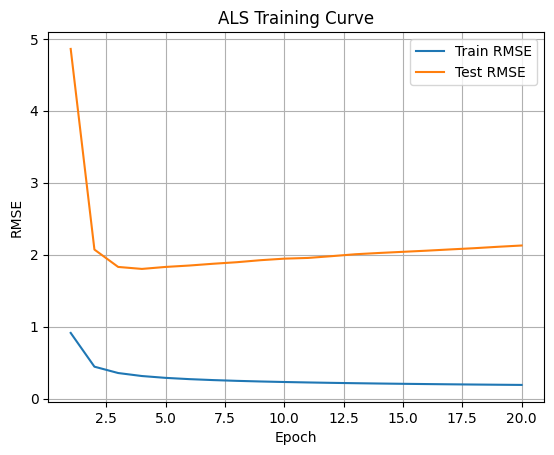

In [5]:
# 📊 Plot RMSE curves
plt.plot(range(1, n_epochs + 1), train_rmse_list, label='Train RMSE')
plt.plot(range(1, n_epochs + 1), test_rmse_list, label='Test RMSE')
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("ALS Training Curve")
plt.legend()
plt.grid(True)
plt.show()
